In [1]:
import pandas as pd
from thoughtfulness_features import *
import os
from nltk.corpus import PlaintextCorpusReader
from nltk import word_tokenize

# Read labelled data

In [2]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_labelled.csv'

In [3]:
df = pd.read_csv(file_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Create thoughtful comment features

In [4]:
df.head()

,Comment,Thoughtful?,Topic
0,Even watching the forbidden p0rn vids are ille...,0,Tracetogether
1,OP make a lot of claims without pointing out t...,0,Tracetogether
2,*pretends to be shocked*,0,Tracetogether
3,"Credit where credit is due, he clearly says Tr...",0,Tracetogether
4,got RTX 3080 anot??,0,Tracetogether


In [5]:
df['Thoughtful?'].sum()

153

## Ceating Feature 1

In [6]:
# Creating feature 1 (Structural feature): comment length
comment_length = []
for row in df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
df['Length'] = comment_length

### Drop rows with comment length == 0

In [7]:
# Removing rows with zero comment length before creating features 2 to 5
df.drop(df[df.Length == 0].index, inplace=True)

# Creating Features 2 to 4

In [8]:
# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

df['Average Loglikelihood'] = comment_likelihood
df['Num Verbs'] = num_verbs
df['Num Discourse Relations'] = num_discourse_relations

In [9]:
df.head()

,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations
0,Even watching the forbidden p0rn vids are ille...,0,Tracetogether,28,-12.470231,6,0
1,OP make a lot of claims without pointing out t...,0,Tracetogether,27,-11.514518,6,1
2,*pretends to be shocked*,0,Tracetogether,4,-10.466185,2,0
3,"Credit where credit is due, he clearly says Tr...",0,Tracetogether,17,-11.904904,5,1
4,got RTX 3080 anot??,0,Tracetogether,4,-18.174303,1,0


# Creating Feature 5

### Reading all the policy docs into a corpus

In [10]:
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')

In [11]:
fid = corpus.fileids()
fid.sort()

In [12]:
doc_words = [corpus.words(f) for f in fid]

In [13]:
fid

['circuit_breaker_policy.txt',
 'safe_distancing_policy.txt',
 'tracetogether_policy.txt',
 'vaccination_policy.txt']

### Splitting the labelled data to its own policy/topic

In [14]:
circuit_breaker_comments = df[df['Topic'] == 'circuit breaker']
safe_distancing_comments = df[df['Topic'] == 'safe distancing']
tracetogether_comments = df[df['Topic'] == 'Tracetogether']
vaccination_comments = df[df['Topic'] == 'vaccination']
comments = [circuit_breaker_comments, safe_distancing_comments, tracetogether_comments, vaccination_comments]

### Calculating KL-divergence relevance score for each comment to its respective policy topic

In [15]:
for i in range(4):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

<ipython-input-15-27b6f5891fa8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments[i]['Relevance score'] = relavance_scores


In [16]:
df_final = pd.concat(comments, ignore_index=True)

In [17]:
df_final['Relevance score'].min()

-0.14334259461816

In [18]:
df_final['Relevance score'].max()

408.44700751757154

In [19]:
df_final.head()

,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
0,🇸🇬New Parc Clematis National Day Promo startin...,0,circuit breaker,34,-13.944796,4,0,5.691875
1,"Oh my fucking God, this announcement could not...",0,circuit breaker,94,-11.286315,16,2,3.849035
2,Dang it. I was super happy for a while.\n\nIt'...,0,circuit breaker,18,-9.626479,3,0,36.848291
3,After a beautiful front 9 we got hit with the ...,0,circuit breaker,11,-13.549426,2,0,26.305341
4,"these people must be tagged, if not cannot ent...",0,circuit breaker,11,-11.213937,2,1,55.383696


In [20]:
df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

# Training the classification model

In [72]:
### Basic Imports
import pandas as pd
import numpy as np

### Graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns 


### Importing the relevant ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,roc_curve,auc,recall_score,f1_score,precision_score,classification_report,confusion_matrix,auc

In [73]:
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

In [74]:
df.head()

,Unnamed: 0,Comment,Thoughtful?,Topic,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
0,0,🇸🇬New Parc Clematis National Day Promo startin...,0,circuit breaker,34,-13.944796,4,0,5.691875
1,1,"Oh my fucking God, this announcement could not...",0,circuit breaker,94,-11.286315,16,2,3.849035
2,2,Dang it. I was super happy for a while.\n\nIt'...,0,circuit breaker,18,-9.626479,3,0,36.848291
3,3,After a beautiful front 9 we got hit with the ...,0,circuit breaker,11,-13.549426,2,0,26.305341
4,4,"these people must be tagged, if not cannot ent...",0,circuit breaker,11,-11.213937,2,1,55.383696


In [75]:
features_list = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
target = 'Thoughtful?'

In [76]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):

    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)

    plt.show()

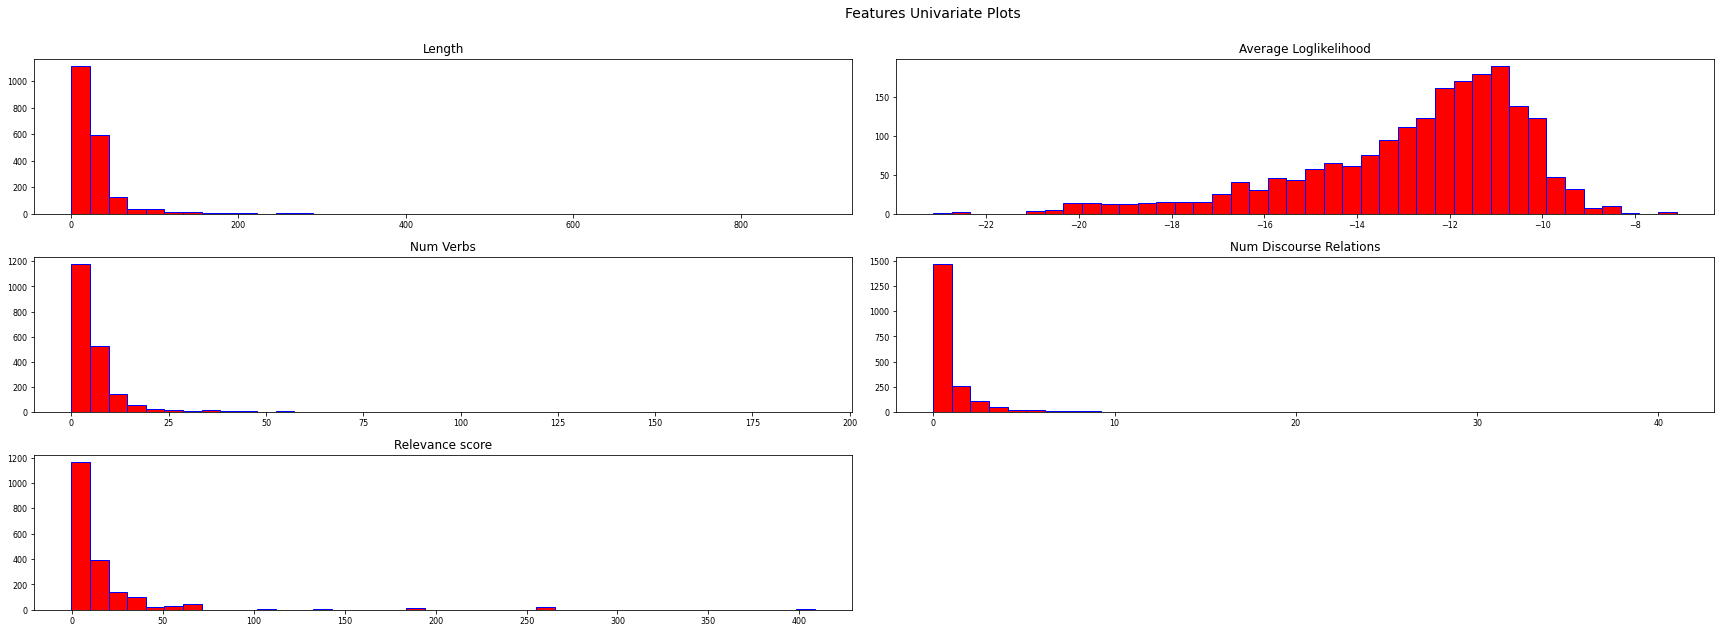

In [77]:
eda_plots(df,features_list,'Features Univariate Plots',(20,7))

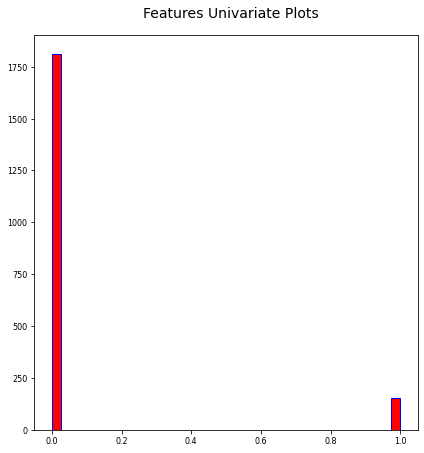

In [78]:
eda_plots(df,target,'Features Univariate Plots',(5,5))

# Standardizing independent variables

In [79]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(df[features_list])
X_scaled = pd.DataFrame(X_scaled, columns=features_list)

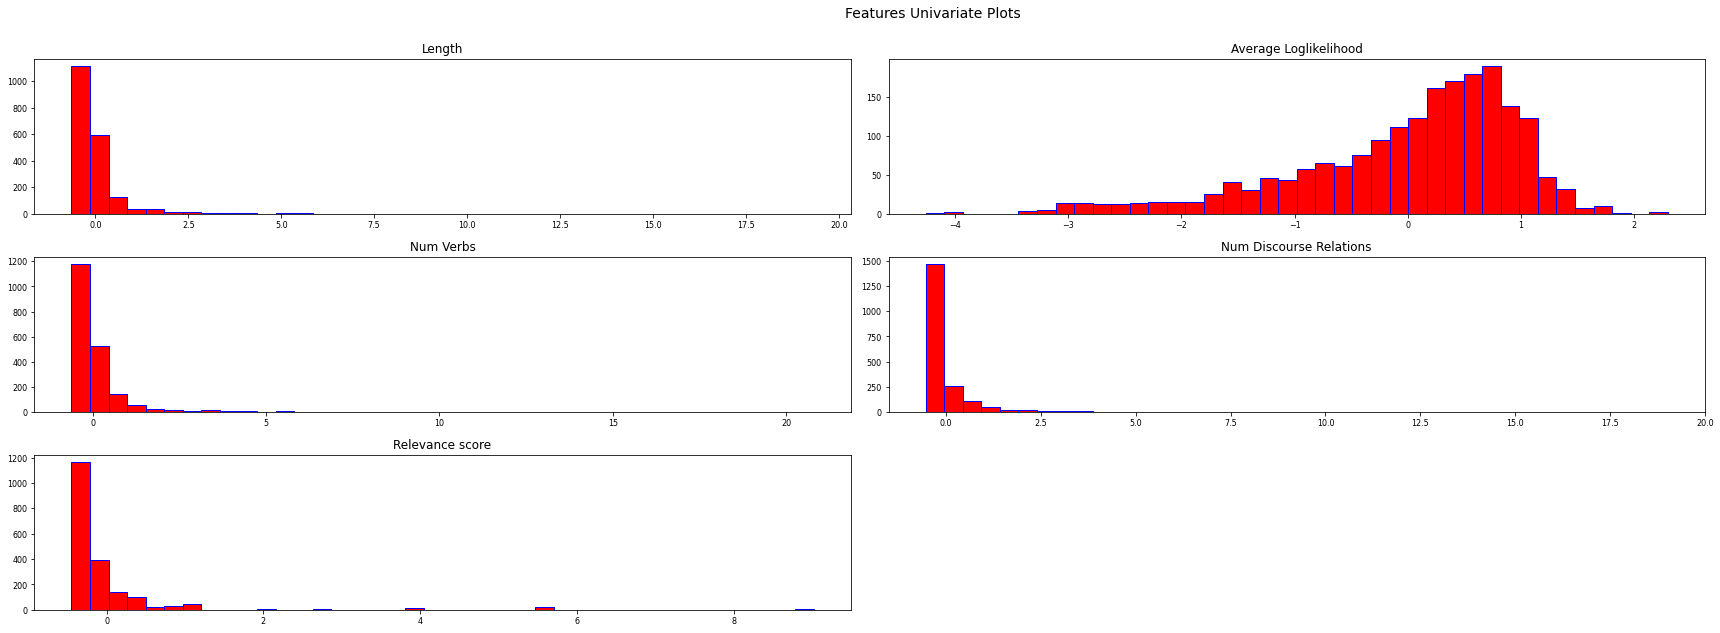

In [80]:
eda_plots(X_scaled,features_list,'Features Univariate Plots',(20,7))

# Training of classficiation model

In [81]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False)
}

performance_data = {}

In [82]:
# Creating our independent and dependent variables df
X = X_scaled[['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df['Thoughtful?']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15) 

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]
    
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.93548
Precision Score for Logistic Regression is 0.75000
Recall Score for Logistic Regression is 0.26087
F1 Score for Logistic Regression is 0.38710

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.92020
Precision Score for Naive Bayes is 0.49057
Recall Score for Naive Bayes is 0.56522
F1 Score for Naive Bayes is 0.52525

Decision Trees
--------------------------------------------------
Accuracy Score for Decision Trees is 0.91681
Precision Score for Decision Trees is 0.45946
Recall Score for Decision Trees is 0.36957
F1 Score for Decision Trees is 0.40964

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.92699
Precision Score for SVM linear is 0.63636
Recall Score for SVM linear is 0.15217
F1 Score for SVM linear is 0.24561

SVM rbf
------------------------------------------

# Stratified K-Fold Sampling

In [83]:
skf = StratifiedKFold(n_splits=10)
target = df['Thoughtful?']

In [84]:
fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    print('Fold',str(fold_no),
          'Class Ratio:',
          sum(test['Thoughtful?'])/len(test['Thoughtful?']))
    fold_no += 1

Fold 1 Class Ratio: 0.08121827411167512
Fold 2 Class Ratio: 0.08121827411167512
Fold 3 Class Ratio: 0.08121827411167512
Fold 4 Class Ratio: 0.07653061224489796
Fold 5 Class Ratio: 0.07653061224489796
Fold 6 Class Ratio: 0.07653061224489796
Fold 7 Class Ratio: 0.07653061224489796
Fold 8 Class Ratio: 0.07653061224489796
Fold 9 Class Ratio: 0.07653061224489796
Fold 10 Class Ratio: 0.07653061224489796


In [85]:
skf = StratifiedKFold(n_splits=10)

X = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

model = LogisticRegression()
best_acc = 0
best_train_set = []
best_test_set = []

fold_no = 1
for train_index, test_index in skf.split(df, target):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]
    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)
    if accuracy_score(y_test,predictions) > best_acc:
        best_acc = accuracy_score(y_test,predictions)
        best_train_set = train
        best_test_set = test
    print('Fold', str(fold_no), 'Accuracy:', accuracy_score(y_test,predictions))

    fold_no += 1

Fold 1 Accuracy: 0.9289340101522843
Fold 2 Accuracy: 0.9187817258883249
Fold 3 Accuracy: 0.934010152284264
Fold 4 Accuracy: 0.9489795918367347
Fold 5 Accuracy: 0.9693877551020408
Fold 6 Accuracy: 0.9489795918367347
Fold 7 Accuracy: 0.9132653061224489
Fold 8 Accuracy: 0.9183673469387755
Fold 9 Accuracy: 0.9285714285714286
Fold 10 Accuracy: 0.9489795918367347


## Cross Validation

In [86]:
X = df[['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df[['Thoughtful?']]

In [90]:
for model_name in models_dict:
    m = models_dict[model_name]
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(m, X.values, y.values.ravel(), scoring=scoring, cv=10)

    print(model_name)
    print('-'*50)
    print(f"Mean accuracy is {scores['test_accuracy'].mean()}")
    print(f"Mean precision is {scores['test_precision'].mean()}")
    print(f"Mean recall is {scores['test_recall'].mean()}")
    print(f"Mean f1 is {scores['test_f1'].mean()}")
    print()
    print()

Logistic Regression
--------------------------------------------------
Mean accuracy is 0.9358256500569769
Mean precision is 0.726839826839827
Mean recall is 0.3095833333333333
Mean f1 is 0.41377870117000554


Naive Bayes
--------------------------------------------------
Mean accuracy is 0.9210245519527607
Mean precision is 0.5168686273746244
Mean recall is 0.5375
Mean f1 is 0.514465825139849


Decision Trees
--------------------------------------------------
Mean accuracy is 0.9042163058116646
Mean precision is 0.3902181152181152
Mean recall is 0.4070833333333333
Mean f1 is 0.38764909532429


SVM linear
--------------------------------------------------
Mean accuracy is 0.9302237646327566
Mean precision is 0.7289682539682539
Mean recall is 0.19791666666666669
Mean f1 is 0.2951400671911508


SVM rbf
--------------------------------------------------
Mean accuracy is 0.92716771987983
Mean precision is 0.6575091575091575
Mean recall is 0.21750000000000003
Mean f1 is 0.30670483025746187


From the cross validation, with 10 stratified k-folds, naives bayes classifier seems to be the best one based on highest recall score and f1 score.

# Perform Random Forest Feature Selection to look at importance of each features

In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [92]:
df = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')

In [93]:
X = df[['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']]
y = df['Thoughtful?']
feat_labels = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [94]:
sel_rfc = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel_rfc.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [95]:
sel_rfc.get_support()

array([ True, False,  True, False,  True])

In [96]:
selected_feat= X_train.columns[(sel_rfc.get_support())]
selected_feat

Index(['Length', 'Num Verbs', 'Relevance score'], dtype='object')

In [97]:
clf = RandomForestClassifier(n_estimators=100, random_state=10)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [98]:
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('Length', 0.29594379239895935)
('Average Loglikelihood', 0.1928636182188799)
('Num Verbs', 0.1916415533153965)
('Num Discourse Relations', 0.09687571883398521)
('Relevance score', 0.22267531723277892)


In [99]:
sfm = SelectFromModel(clf)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=10))

In [100]:
sfm.get_support()

array([ True, False, False, False,  True])

In [101]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Length
Relevance score


# Testing against validation data

## Preparing validation data thoughtful comments features

In [117]:
path_parent = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = f'{path_parent}/Data/Thoughtful Comments/validation_comments.xls'

In [118]:
validation_df = pd.read_excel(file_path)

In [119]:
validation_df.head()

,Unnamed: 0,Comment,Topic,Thoughtful?
0,0,Moderna: Covid vaccine shows nearly 95% protec...,Vaccination,0
1,1,It is advanced lab rats,Vaccination,0
2,2,"@JFN1971 i don't have cancer, i don't need an ...",Vaccination,0
3,3,Who's approved which vaccines in Southeast Asi...,Vaccination,0
4,4,China's Covid-19 vaccine drive is falling behi...,Vaccination,0


### Creating feature 1

In [120]:
comment_length = []
for row in validation_df['Comment']:
    length = get_comment_length(row)
    comment_length.append(length)
validation_df['Length'] = comment_length

In [121]:
# Removing rows with zero comment length before creating features 2 to 5
validation_df.drop(validation_df[validation_df.Length == 0].index, inplace=True)

### Creating feature 2 to 4

In [122]:
# Preparation for feature 2 (Lexical feature): comment likelihood
comment_likelihood = []
# news_unigram = news_articles_unigram(f'{path_parent}/Data/News Article/articles1.csv')

# Preparation for feature 3 (Syntatic feature): number of verbs
num_verbs = []

# Preparation for feature 4 (Discourse feature): number of discourse relations
num_discourse_relations = []

for row in validation_df['Comment']:
    # Creating feature 2 
    cmt_text_counter = comment_unicounter(row)
    cmt_loglikelihood = news_unigram.evaluate(cmt_text_counter)
    comment_likelihood.append(cmt_loglikelihood)

    # Creating feature 3
    verbs_count = get_num_verbs(row)
    num_verbs.append(verbs_count)

    # Creating feature 4
    discourse_count = num_discourse(row)
    num_discourse_relations.append(discourse_count)

validation_df['Average Loglikelihood'] = comment_likelihood
validation_df['Num Verbs'] = num_verbs
validation_df['Num Discourse Relations'] = num_discourse_relations

### Creating feature 5

In [123]:
corpus = PlaintextCorpusReader(f'{path_parent}/Data/Policy Documents/', '.+\.txt', encoding='utf-8')

In [124]:
fid = corpus.fileids()
fid.sort()
fid

['circuit_breaker_policy.txt',
 'safe_distancing_policy.txt',
 'tracetogether_policy.txt',
 'vaccination_policy.txt']

In [125]:
doc_words = [corpus.words(f) for f in fid]
doc_words = [doc_words[0], doc_words[3]]
doc_words

[['The', '2020', 'Singapore', 'circuit', 'breaker', ...],
 ['After', 'studying', 'the', 'scientific', 'evidence', ...]]

In [126]:
circuit_breaker_comments = validation_df[validation_df['Topic'] == 'Circuit Breaker']
vaccination_comments = validation_df[validation_df['Topic'] == 'Vaccination']

In [127]:
circuit_breaker_comments.head()

,Unnamed: 0,Comment,Topic,Thoughtful?,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations
300,300,Sim Lim has certain repair shops open. I went ...,Circuit Breaker,0,17,-12.088614,5,0
301,301,Can’t believe even up to date after the announ...,Circuit Breaker,0,31,-11.000176,6,2
302,302,"Complain to your poly. Anyway, unless you are ...",Circuit Breaker,0,15,-12.218247,3,0
303,303,Choose your designs for the table sticker for...,Circuit Breaker,0,13,-17.955011,1,0
304,304,Post Circuit Breaker Day 36 : Doom Day.. Take ...,Circuit Breaker,0,11,-19.492508,0,0


In [128]:
comments = [circuit_breaker_comments, vaccination_comments]

In [130]:
for i in range(2):
    doc_unigram, doc_nouns = topic_doc_unigram(doc_words[i], k=1)
    relavance_scores = []
    for row in comments[i]['Comment']:
        cmt_unigram, cmt_nouns = comment_unigram(row, k=1)
        score = KLDiv_relevance_score(doc_unigram, cmt_unigram, doc_nouns, cmt_nouns)
        relavance_scores.append(score)
    comments[i]['Relevance score'] = relavance_scores

<ipython-input-130-69edaa2c8fae>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments[i]['Relevance score'] = relavance_scores


In [131]:
circuit_breaker_comments.head()

,Unnamed: 0,Comment,Topic,Thoughtful?,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score
300,300,Sim Lim has certain repair shops open. I went ...,Circuit Breaker,0,17,-12.088614,5,0,16.878383
301,301,Can’t believe even up to date after the announ...,Circuit Breaker,0,31,-11.000176,6,2,9.601581
302,302,"Complain to your poly. Anyway, unless you are ...",Circuit Breaker,0,15,-12.218247,3,0,26.407151
303,303,Choose your designs for the table sticker for...,Circuit Breaker,0,13,-17.955011,1,0,10.280064
304,304,Post Circuit Breaker Day 36 : Doom Day.. Take ...,Circuit Breaker,0,11,-19.492508,0,0,8.468110


In [132]:
df_final = pd.concat(comments, ignore_index=True)

In [133]:
df_final['Relevance score'].max()

408.44700751757154

In [134]:
df_final['Relevance score'].min()

0.22586279731924508

In [135]:
df_final[df_final['Relevance score'] == 0]

,Unnamed: 0,Comment,Topic,Thoughtful?,Length,Average Loglikelihood,Num Verbs,Num Discourse Relations,Relevance score


In [136]:
df_final.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

## Testing trained model against validation data

In [137]:
training_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/thoughtful_comments_final.csv')
validation_data = pd.read_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_final.csv')

In [138]:
# Creating our independent and dependent variables df
X = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

# Training with differnent models
for model_name in models_dict:
    m = models_dict[model_name]

    X_train = training_data[X]
    y_train = training_data[y]
    X_test = validation_data[X]
    y_test = validation_data[y]
    
    m.fit(X_train, y_train.values.ravel())
    predictions = m.predict(X_test)

    acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    print(model_name)
    print('-'*50)
    print('Accuracy Score for {} is {:.5f}'.format(model_name,acc))
    print('Precision Score for {} is {:.5f}'.format(model_name,precision))
    print('Recall Score for {} is {:.5f}'.format(model_name,recall))
    print('F1 Score for {} is {:.5f}'.format(model_name,f1))
    print()

Logistic Regression
--------------------------------------------------
Accuracy Score for Logistic Regression is 0.91062
Precision Score for Logistic Regression is 0.69231
Recall Score for Logistic Regression is 0.15517
F1 Score for Logistic Regression is 0.25352

Naive Bayes
--------------------------------------------------
Accuracy Score for Naive Bayes is 0.91568
Precision Score for Naive Bayes is 0.61111
Recall Score for Naive Bayes is 0.37931
F1 Score for Naive Bayes is 0.46809

Decision Trees
--------------------------------------------------
Accuracy Score for Decision Trees is 0.89207
Precision Score for Decision Trees is 0.42105
Recall Score for Decision Trees is 0.27586
F1 Score for Decision Trees is 0.33333

SVM linear
--------------------------------------------------
Accuracy Score for SVM linear is 0.91231
Precision Score for SVM linear is 1.00000
Recall Score for SVM linear is 0.10345
F1 Score for SVM linear is 0.18750

SVM rbf
------------------------------------------

In [139]:
model = GaussianNB()

X = ['Length', 'Average Loglikelihood', 'Num Verbs', 'Num Discourse Relations', 'Relevance score']
y = ['Thoughtful?']

X_train = training_data[X]
y_train = training_data[y]
X_test = validation_data[X]
y_test = validation_data[y]
model.fit(X_train, y_train.values.ravel())
predictions = model.predict(X_test)

acc = accuracy_score(y_test,predictions)  
precision = precision_score(y_test,predictions) 
recall = recall_score(y_test,predictions) 
f1 = f1_score(y_test,predictions)

print('Accuracy Score is {:.5f}'.format(acc))
print('Precision Score is {:.5f}'.format(precision))
print('Recall Score is {:.5f}'.format(recall))
print('F1 Score is {:.5f}'.format(f1))

Accuracy Score is 0.91568
Precision Score is 0.61111
Recall Score is 0.37931
F1 Score is 0.46809


In [140]:
validation_data['Prediction'] = predictions

### Number of comments correctly predicted as thoughtful

In [141]:
len(validation_data[(validation_data['Prediction'] == 1) & (validation_data['Thoughtful?'] == 1)])

22

### Number of actual labelled thoughtful comments

In [142]:
validation_data['Thoughtful?'].sum()

58

In [143]:
# validation_data.to_csv(f'{path_parent}/Data/Thoughtful Comments/validation_comments_prediction.csv')

acc, prec, rec, f1 scores for previous policy documents.
Accuracy Score is 0.91737
Precision Score is 0.62857
Recall Score is 0.37931
F1 Score is 0.47312